In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, classification_report, roc_curve, plot_roc_curve, auc, precision_recall_curve, plot_precision_recall_curve, average_precision_score
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import balanced_accuracy_score


In [ ]:
df = pd.read_csv('https://github.com/tzekiattok/strokedata/blob/main/healthcare-dataset-stroke-data.csv?raw=true')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


### 1. Impute missing values (BMI) with Decision Tree Regressor

In [ ]:
DT_bmi_pipe = Pipeline( steps=[ 
                               ('scale',StandardScaler()),
                               ('lr',DecisionTreeRegressor(random_state=0))
                              ])
X = df[['age','gender','bmi']].copy()
X.gender = X.gender.replace({'Male':0,'Female':1,'Other':-1}).astype(np.uint8)

Missing = X[X.bmi.isna()]
X = X[~X.bmi.isna()]
Y = X.pop('bmi')
DT_bmi_pipe.fit(X,Y)
predicted_bmi = pd.Series(DT_bmi_pipe.predict(Missing[['age','gender']]),index=Missing.index)
df.loc[Missing.index,'bmi'] = predicted_bmi

In [ ]:
residence_type = df['Residence_type'].unique()
ever_married = df['ever_married'].unique()
le = LabelEncoder()

le.fit(residence_type)
df['Residence_type'] = le.transform(df['Residence_type'])

le.fit(ever_married)
df['ever_married'] = le.transform(df['ever_married'])

### 2. OneHotEncode Categorical values

In [ ]:
df_encoded = df
df_encoded= pd.concat([df_encoded, pd.get_dummies(df_encoded['work_type'], prefix = 'work_type=')], axis = 1).drop(['work_type'], axis = 1)
df_encoded= pd.concat([df_encoded, pd.get_dummies(df_encoded['smoking_status'], prefix = 'smoking_status=')], axis = 1).drop(['smoking_status'], axis = 1)
df_encoded= pd.concat([df_encoded, pd.get_dummies(df_encoded['gender'], prefix = 'gender=')], axis = 1).drop(['gender'], axis = 1)
df1=df_encoded
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   id                               5110 non-null   int64  
 1   age                              5110 non-null   float64
 2   hypertension                     5110 non-null   int64  
 3   heart_disease                    5110 non-null   int64  
 4   ever_married                     5110 non-null   int64  
 5   Residence_type                   5110 non-null   int64  
 6   avg_glucose_level                5110 non-null   float64
 7   bmi                              5110 non-null   float64
 8   stroke                           5110 non-null   int64  
 9   work_type=_Govt_job              5110 non-null   uint8  
 10  work_type=_Never_worked          5110 non-null   uint8  
 11  work_type=_Private               5110 non-null   uint8  
 12  work_type=_Self-empl

### 3. Define X & y

In [ ]:
X = df1[['age', 'hypertension', 'heart_disease','ever_married','Residence_type', 'avg_glucose_level', 'bmi', 'work_type=_Govt_job','work_type=_Never_worked','work_type=_Private','work_type=_Self-employed','work_type=_children','Residence_type','smoking_status=_Unknown','smoking_status=_formerly smoked','smoking_status=_never smoked','smoking_status=_smokes','gender=_Female','gender=_Male','gender=_Other']]
y = df1['stroke']
Columns = ['age', 'hypertension', 'heart_disease','ever_married','Residence_type', 'avg_glucose_level', 'bmi', 'work_type=_Govt_job','work_type=_Never_worked','work_type=_Private','work_type=_Self-employed','work_type=_children','Residence_type','smoking_status=_Unknown','smoking_status=_formerly smoked','smoking_status=_never smoked','smoking_status=_smokes','gender=_Female','gender=_Male','gender=_Other']
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 20 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   age                              5110 non-null   float64
 1   hypertension                     5110 non-null   int64  
 2   heart_disease                    5110 non-null   int64  
 3   ever_married                     5110 non-null   int64  
 4   Residence_type                   5110 non-null   int64  
 5   avg_glucose_level                5110 non-null   float64
 6   bmi                              5110 non-null   float64
 7   work_type=_Govt_job              5110 non-null   uint8  
 8   work_type=_Never_worked          5110 non-null   uint8  
 9   work_type=_Private               5110 non-null   uint8  
 10  work_type=_Self-employed         5110 non-null   uint8  
 11  work_type=_children              5110 non-null   uint8  
 12  Residence_type      

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.preprocessing import StandardScaler 
X_train_smote, X_test, y_train_smote, y_test = train_test_split(X, y, test_size= 0.2, random_state= 0)

sc = StandardScaler()
X_train_smote = sc.fit_transform(X_train_smote)
X_test = sc.transform(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


### 4. Train Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 424)


### 5. Apply SMOTE

In [ ]:
X_test_original = X_test
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
smote = SMOTE(random_state = 424)
# fit predictor and target variable
X_train_smote, y_train_smote =  smote.fit_resample(X_train, y_train.ravel())
print('Original dataset shape', Counter(y_train))
print('Resample dataset shape', Counter(y_train_smote))


Original dataset shape Counter({0: 3892, 1: 196})
Resample dataset shape Counter({0: 3892, 1: 3892})


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


### 6. Apply PCA

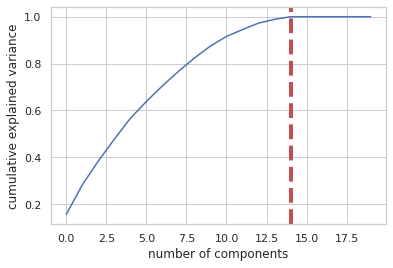

None

,Cumulative Variance Ratio,Explained Variance Ratio
0,0.156381,0.156381
1,0.282717,0.126336
2,0.384572,0.101854
3,0.477503,0.092931
4,0.566596,0.089094
5,0.638375,0.071778
6,0.704978,0.066603
7,0.766781,0.061804
8,0.824036,0.057254
9,0.875066,0.051031


In [ ]:
pca_test = PCA(n_components=20)
pca_test.fit(X_train_smote)
sns.set(style='whitegrid')
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axvline(linewidth=4, color='r', linestyle = '--', x=14, ymin=0, ymax=1)
display(plt.show())
evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
display(pca_df.head(14))

In [ ]:
# View top variables
pca = PCA(n_components=12)
pca.fit(X_train_smote)

X_train_smote = pca.transform(X_train_smote)
X_test = pca.transform(X_test)

In [ ]:
# View correlation of PCA features
pca_dims = []
for x in range(0, len(pca_df)):
    pca_dims.append('PCA Component {}'.format(x))
pca_test_df = pd.DataFrame(pca_test.components_, columns=Columns, index=pca_dims)
pca_test_df.head(12).T

,PCA Component 0,PCA Component 1,PCA Component 2,PCA Component 3,PCA Component 4,PCA Component 5,PCA Component 6,PCA Component 7,PCA Component 8,PCA Component 9,PCA Component 10,PCA Component 11
age,0.404495,-0.214556,-0.058973,-0.007755,-0.062474,0.024887,0.103191,-0.104955,-0.057981,-0.013647,-0.399943,-0.252175
hypertension,0.284716,-0.295618,0.104124,0.204207,0.068075,-0.270048,-0.415863,0.630349,0.044114,0.336718,-0.071425,0.072625
heart_disease,0.514431,0.370388,-0.055528,-0.067226,0.503584,0.318754,-0.050115,-0.100757,-0.363238,0.240195,0.065934,0.129299
ever_married,0.283235,-0.161152,-0.034693,-0.086552,-0.138265,0.016289,0.155176,-0.107336,0.085369,-0.063416,-0.376301,-0.130218
Residence_type,0.017971,0.147332,-0.605162,0.291954,-0.125445,-0.086127,-0.047411,0.002188,-0.015613,0.016851,-0.003274,-0.008835
avg_glucose_level,0.346949,-0.005080,-0.015033,-0.036924,0.105259,-0.027912,-0.451722,-0.063602,0.216327,-0.685019,0.279794,-0.217374
bmi,0.197857,-0.086982,-0.056265,-0.121403,-0.136869,-0.071168,0.011429,-0.080335,0.168399,-0.191311,-0.004652,0.818046
work_type=_Govt_job,0.011901,-0.075969,-0.032424,0.087761,0.125913,0.248033,-0.175239,-0.332484,0.645341,0.338215,-0.119628,0.001732
work_type=_Never_worked,-0.031243,0.012135,-0.006036,0.021728,0.018894,-0.019605,-0.013824,-0.017932,-0.006896,0.019509,0.124539,0.358915
work_type=_Private,0.086112,0.163217,-0.118540,-0.547514,-0.270282,-0.253342,-0.057999,0.113508,-0.223533,0.013569,-0.075457,-0.041317


### Fit into the model (Logistic Regression)

In [ ]:
lr = LogisticRegression(random_state =424,max_iter=5000)
lr.fit(X_train_smote,y_train_smote)
y_pred_lr = lr.predict(X_test)

conf_matrix_lr = confusion_matrix(y_test,y_pred_lr)
accuracy = accuracy_score(y_test,y_pred_lr)
precision = metrics.precision_score(y_test,y_pred_lr) 
recall = metrics.recall_score(y_test,y_pred_lr) 
f1_score = metrics.f1_score(y_test,y_pred_lr) 

accuracies = cross_val_score(estimator = lr, X = X_train_smote, y = y_train_smote, cv = 10)   #K-Fold Validation
roc = roc_auc_score(y_test, y_pred_lr)  #ROC AUC Score
print(conf_matrix_lr, '\n Accuracy:',
      accuracy,'\n Precision:',  precision,'\n Recall:',  recall,'\n f1_score:',  f1_score,'\n Kfold validation:',accuracies,'\n ROC AUC Score:',roc)


[[653 316]
 [ 10  43]] 
 Accuracy: 0.6810176125244618 
 Precision: 0.11977715877437325 
 Recall: 0.8113207547169812 
 f1_score: 0.20873786407766992 
 Kfold validation: [0.73042362 0.76636714 0.77021823 0.76379974 0.78663239 0.75835476
 0.74807198 0.77120823 0.73907455 0.75192802] 
 ROC AUC Score: 0.742605681796055


In [ ]:
# Tuning hyperparams with GridsearchCV

In [ ]:
#Configure Hyperparams

log_models = [(LogisticRegression(),[{'C':[0.25,0.5,0.75,1],'random_state':[424],'max_iter':[50000],'solver':['lbfgs','saga','sag']}])]

In [ ]:
# Get best hyperparams

for i,j in log_models:
    grid = GridSearchCV(estimator=i,param_grid = j, scoring = 'roc_auc',cv = 10)
    grid.fit(X_train_smote, y_train_smote)
    best_accuracy = grid.best_score_
    best_param = grid.best_params_
    print('{}:\nBest Accuracy : {:.2f}%'.format(i,best_accuracy*100))
    print('Best Parameters : ',best_param)
    print('')
    print('----------------')
    print('')

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False):
Best Accuracy : 82.86%
Best Parameters :  {'C': 0.75, 'max_iter': 50000, 'random_state': 424, 'solver': 'sag'}

----------------



Accuracy: 0.6810176125244618 
 Precision: 0.11977715877437325 
 Recall: 0.8113207547169812 
 f1_score: 0.20873786407766992 

              precision    recall  f1-score   support

           0       0.98      0.67      0.80       969
           1       0.12      0.81      0.21        53

    accuracy                           0.68      1022
   macro avg       0.55      0.74      0.50      1022
weighted avg       0.94      0.68      0.77      1022

ROC AUC score: 0.8123332749187062
Accuracy Score:  0.6810176125244618
Balanced Accuracy Score:  0.7426056817960551


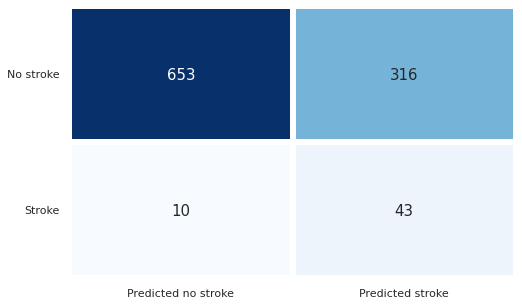

Text(0.5, 0, 'False Positive Rate')

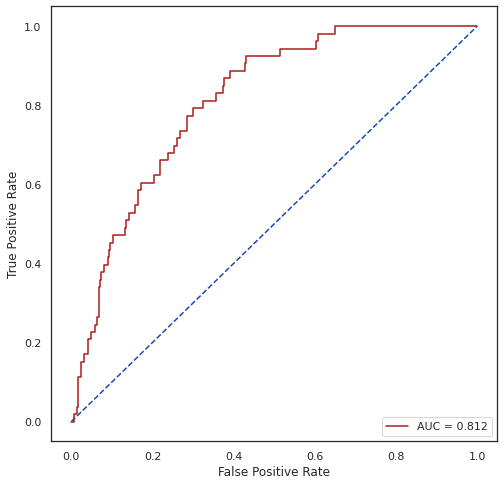

In [ ]:
# Display results with hyperparameterized model

lr = LogisticRegression(random_state =424,max_iter=5000, C = 0.25,solver = 'sag')
lr.fit(X_train_smote,y_train_smote)
y_pred_lr = lr.predict(X_test)
y_prob = lr.predict_proba(X_test)[:,1]
cm = confusion_matrix(y_test, y_pred_lr)

accuracy = accuracy_score(y_test, y_pred_lr)
precision = metrics.precision_score(y_test, y_pred_lr) 
recall = metrics.recall_score(y_test, y_pred_lr) 
f1_score = metrics.f1_score(y_test, y_pred_lr) 
print('Accuracy:',
      accuracy,'\n Precision:',  precision,'\n Recall:',  recall,'\n f1_score:',  f1_score, '\n')


print(classification_report(y_test, y_pred_lr))
print(f'ROC AUC score: {roc_auc_score(y_test, y_prob)}')
print('Accuracy Score: ',accuracy_score(y_test, y_pred_lr))
print('Balanced Accuracy Score: ',balanced_accuracy_score(y_test, y_pred_lr))

# Visualizing Confusion Matrix
plt.figure(figsize = (8, 5))
sns.heatmap(cm, cmap = 'Blues', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 15}, 
            yticklabels = ['No stroke', 'Stroke'], xticklabels = ['Predicted no stroke', 'Predicted stroke'])
plt.yticks(rotation = 0)
plt.show()

# Roc Curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)

sns.set_theme(style = 'white')
plt.figure(figsize = (8, 8))
plt.plot(false_positive_rate,true_positive_rate, color = '#b01717', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')